In [3]:
import sys
sys.path.append('/home/akshay/proj/ephys_analysis')
from myinit import *
import pandas as pd

import json

# Load data

In [4]:
# Wrong way
# metadata = pd.read_json('behavior_trials/cueconflict_trials_merged_2025-01.json')
# data = pd.read_json('behavior_trials/texture-shape_experiment_20250122_data.json')
# behav_data = data[data.task=='matchtosample'].copy()[['subject_id', 'trial_id', 'tasktype', 'stim_set', 'sample', 
#                                                       'choice1', 'choice2', 'response', 'subject_choice', 'correct_choice',
#                                                       'subject_choice_num', 'rt', 
#                                                       'sample_duration', ]].rename(columns={'choice1': 'choice_left', 
#                                                                                             'choice2': 'choice_right',
#                                                                                             'subject_choice_num': 'response_num',                                                                                            
#                                                                                            })
# behav_data['response'].replace({'arrowleft': 'left', 'arrowright': 'right'}, inplace=True)
# behav_data['subject_correct'] = (behav_data['subject_choice']==behav_data['correct_choice'])
# behav_data

In [5]:
with open('behavior_trials/cueconflict_trials_merged_2025-01.json', 'rb') as f:
    metadata = json.load(f)
with open('behavior_trials/texture-shape_experiment_20250122_data.json', 'rb') as f:
    data = json.load(f)

response_keys = ['arrowleft', 'arrowright']
postq_choices = ['Mostly shape', 'Mostly texture', 'Mostly color', 'No consistent strategy', "Didn't think about it, just went with my gut"]

behav_data = {}
for i in range(len(data)):
    if 'subject_id' not in data[i]:
        data[i]['subject_id'] = 'nan'

unique_subjs = np.unique([data[i]['subject_id'] for i in range(len(data))])

for subj in unique_subjs:
    subj_trials = list(filter(lambda trial: trial['subject_id']==subj, data))
    if len(subj_trials)<250:
        continue
    
    nTrials = []
    
    subj_task_trials = list(filter(lambda trial: trial['task']!='postquestion', subj_trials))
    subjs, response, RT, sample, sample_duration, choice0, choice1, tasktype, stim_set, trialids, strategy = [],[],[],[],[],[],[],[],[],[], []
    
    postq_trial = list(filter(lambda trial: trial['task']=='postquestion', subj_trials))[0]
    postq_resp = postq_choices[postq_trial['response']]
    
    for ti, trial in enumerate(subj_task_trials):
        strategy.append(postq_resp)
        subjs.append(subj)
        stim_set.append(trial['stim_set'])
        RT.append(trial['rt'])
        sample.append(trial['sample'])
        sample_duration.append(trial['sample_duration'])
        
        trialid = trial['trial_id']
        trialids.append(trialid)
        
        if trial['stim_set'] == 'shapenet' and trial['tasktype']=='texvscateg':
            tasktype.append('texcolvscateg')
        elif trial['stim_set'] == 'shapenet' and trial['tasktype']=='texvsexemplar':
            tasktype.append('texcolvsexemplar')
        else:
            tasktype.append(trial['tasktype'])
        

        # trialinfo = cc_trial_info if 'cue' in trial['tasktype'] else trial_info
        trialinfo = metadata
        choiceorder = trialinfo['choice_order']

        # i = ti-200 if 'cue' in trial['tasktype'] else ti
        i = ti - 200 if trial['sample_duration'] < 500 else ti

        # Choice images presented to the left and right
        choice0_i = trialinfo['choice_imgs'][trialid][choiceorder[i][0]]
        choice1_i = trialinfo['choice_imgs'][trialid][choiceorder[i][1]]
        
        if choiceorder[i] == [0,1]:
            response.append(response_keys.index(trial['response']))
            choice0.append(choice0_i)
            choice1.append(choice1_i)
        else:
            response.append(1-response_keys.index(trial['response']))
            choice0.append(choice1_i)
            choice1.append(choice0_i)
        
    behav_data[subj] = {'subject_id': subjs,
                        'response': response,
                        'RT': RT,
                        'sample': sample,
                        'choice0': choice0,
                        'choice1': choice1,
                        'sample_duration': sample_duration,
                        'tasktype': tasktype,
                        'stim_set': stim_set,
                        'trial_id': trialids,
                        'strategy': strategy
                       }
behav_df = pd.concat([pd.DataFrame(behav_data[subj]) for subj in behav_data]).reset_index()

In [6]:
# Exclude subjects who performed poorer than 70% on the easiest condition
mean_resp = behav_df[behav_df['tasktype']=='texcolcategvsnone'].groupby('subject_id')['response'].mean()
subj_inc = mean_resp[mean_resp > 0.7].index
behav_df = behav_df[behav_df.subject_id.isin(subj_inc)]

In [49]:
behav_df.to_parquet(f'data/human-behavior-data_jan2025.parquet')

# Process

In [63]:
from load_neural_data import load_from_hdf5
data_sty = load_from_hdf5('data/objaverse-shapenet-stylized_ephys-data_2024.h5')

In [73]:
stimulus_metadata = data_sty['baby1_240117-240419']['repavg']['stimulus_metadata'].copy()
img_fns_unique = np.array(list(map(lambda x: os.path.splitext(x.decode('utf-8'))[0], data_sty['baby1_240117-240419']['repavg']['stimulus_name'])))

In [92]:
# df = behavior.copy()[behavior.stim_set == 'objaverse']

df = behav_df.copy()

# Parse the filename to determine which condition was shown on each trial.
subcategs = {'monkey': ['baboon', 'gorilla', 'monkey'],
             'pan': ['fryingpan', 'saucepan'],
             'person': ['labcoat', 'overalls', 'person', 'suit', 'sweatshirt', 'tank', 'trenchcoat',],
            }
supercategs = {vi:k for k,v in subcategs.items() for vi in v }
animacy = {'animate': ['baboon', 'gorilla', 'monkey', 'labcoat', 'overalls', 'person', 'suit', 'sweatshirt', 'tank', 'trenchcoat', 
                       'glove', 'elephant', 'puppy', 'teddybear'],
           'inanimate': ['fryingpan', 'saucepan', 'alarmclock', 'bagel', 'bicycle', 'car', 'jetplane', 'pan', 'sofa', 'trashcan'],
          }
animacy = {vi:k for k,v in animacy.items() for vi in v}

get_fullpath = lambda x: sess['concat_sess']['image_fullpaths'][np.where(sess['img_fns_unique']== x )[0][0]]

decode_utf = lambda arr: np.array(list(map(lambda x: x.decode('utf-8'), arr)))

for img in ['sample', 'choice0', 'choice1']:
    indices = np.array(list(map(lambda x: np.where(img_fns_unique == x)[0][0], df[img])))
    
    df[f'{img}_fullpath'] = stimulus_metadata['full_path'][indices]
    
    # Add new column for each of the image variables (category, texture, color, etc.)
    df[f'{img}_categ'] = np.array(list(map(lambda x: x.decode('utf-8'), stimulus_metadata['category'][indices])))
    df[f'{img}_object'] = decode_utf(stimulus_metadata['object'][indices])
    df[f'{img}_objview'] = decode_utf(stimulus_metadata['object_viewpoint'][indices])
    df[f'{img}_texture'] = decode_utf(stimulus_metadata['texture'][indices])
    df[f'{img}_pattern'] = decode_utf(stimulus_metadata['pattern'][indices])
    df[f'{img}_color'] = decode_utf(stimulus_metadata['color'][indices])
    df[f'{img}_animacy'] = decode_utf(stimulus_metadata['animacy'][indices])

# df.loc[(df.tasktype=='texvscateg')*(df.choice0_texture==df.sample_texture)*(df.choice0_color==df.sample_color), 'tasktype'] = 'texcolvscateg'
df.loc[(df.tasktype=='texvscateg')*(df.choice0_color!=df.sample_color), 'tasktype'] = 'patternvscateg'
df.loc[(df.tasktype=='texvscateg')*(df.choice0_color==df.sample_color), 'tasktype'] = 'texcolvscateg'

behav_df = df.copy()

In [84]:
behav_df = df.copy()
behav_df.to_parquet(f'data/human-behavior-data_jan2025_processed.parquet')

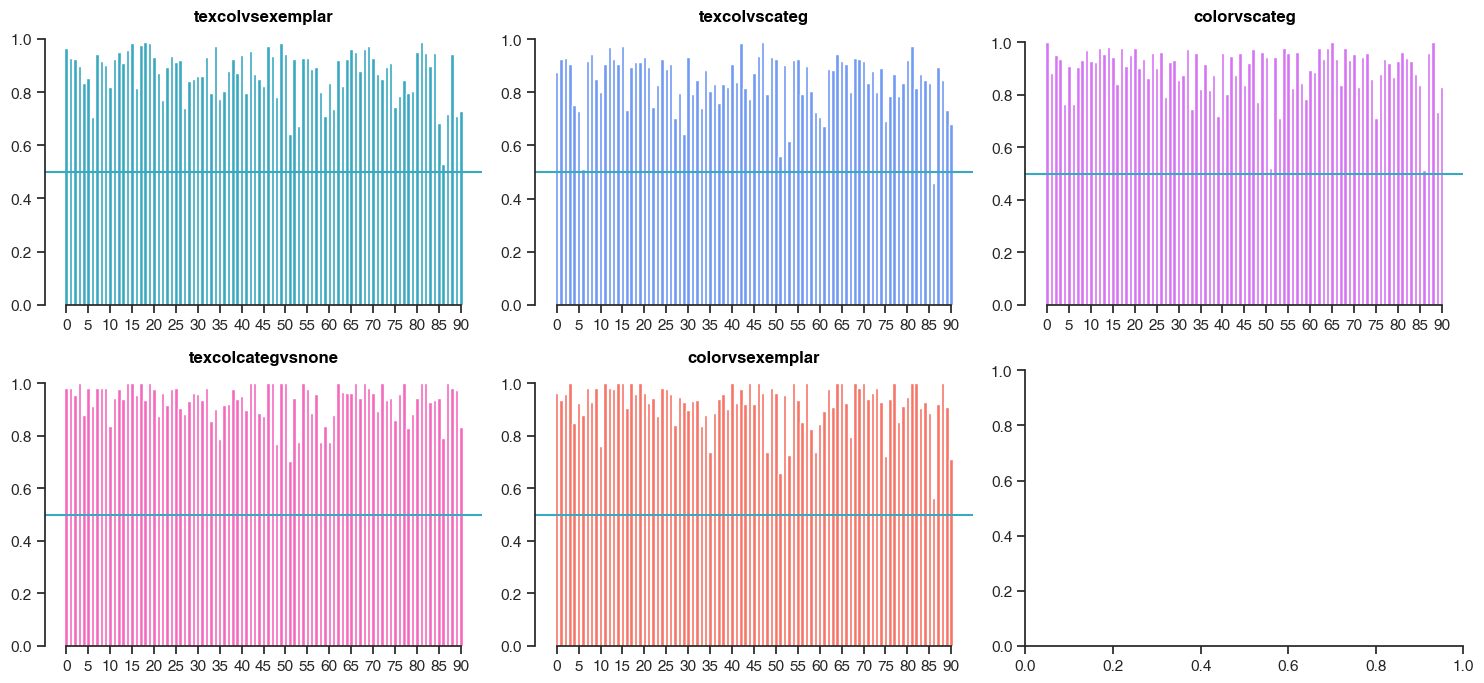

In [7]:
fig, axes = plt.subplots(2,3, figsize=(15,7))

colors = sns.husl_palette(h=0.6, n_colors=9)

for ti, tasktype in enumerate(behav_df.tasktype.unique()):
    ax = axes.ravel()[ti]
    for si, subj in enumerate(behav_df.subject_id.unique()):
        Y = behav_df[(behav_df.tasktype == tasktype)*(behav_df.subject_id==subj)].response.mean()
        if Y == np.nan: Y = 0
        ax.bar(si, Y,
                   color = colors[ti],)
    ax.axhline(0.5)
    ax.set_title(tasktype)
    ax.set_xticks(np.arange(len(behav_df.subject_id.unique()))[::5]);
fig.tight_layout()
sns.despine(trim=True)

2 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


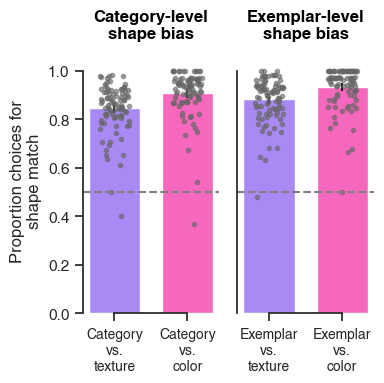

In [31]:
df = behav_df[behav_df.sample_duration == 500].copy().reset_index(drop=True)

colors = sns.husl_palette(h=0.6, n_colors=6)
colors = [colors[1], colors[2]]
fig, axes = plt.subplots(1,2,figsize=(4,4))

ax = axes[0]
b0 = sns.color_palette('colorblind')[0]
tasktypes = ['texcolvscateg',  'colorvscateg',]
labels = ['Category\nvs.\ntexture','Category\nvs.\ncolor',  ]
colshifts = np.linspace(.9, 1.1, len(tasktypes))
for ti, tasktype in enumerate(tasktypes):
    R = df[(df.tasktype == tasktype)].response

    ax.bar(ti, R.agg(np.nanmean), yerr=SE(df[(df.tasktype == tasktype)].groupby('subject_id').response.mean()),
           color = colors[ti], width=.7)
    
    for si, subj in enumerate(df.subject_id.unique()):
        R = df[(df.tasktype == tasktype) * (df.subject_id == subj)].response
        ax.plot(ti + np.random.rand()*0.4 - 0.2, 
                R.mean(), marker = '.', color = [.4,.4,.4], alpha=0.6,)
                
ax.axhline(0.5, color='gray', ls='--')
ax.set_title('Category-level\nshape bias')
ax.set_xticks(np.arange(len(tasktypes)), labels, fontsize=10)
ax.set_ylim(0,1.1)
ax.set_ylabel('Proportion choices for\nshape match')

ax = axes[1]
tasktypes =  ['texcolvsexemplar','colorvsexemplar']
labels = ['Exemplar\nvs.\ntexture', 'Exemplar\nvs.\ncolor', ]
colshifts = np.linspace(.9, 1.1, len(tasktypes))
for ti, tasktype in enumerate(tasktypes):
    R = df[(df.tasktype == tasktype)].response

    ax.bar(ti, R.agg(np.nanmean), yerr=SE(df[(df.tasktype == tasktype)].groupby('subject_id').response.mean()),
           color = colors[ti], width=.7)
    
    for si, subj in enumerate(df.subject_id.unique()):
        R = df[(df.tasktype == tasktype) * (df.subject_id == subj)].response
        ax.plot(ti + np.random.rand()*0.4 - 0.2, 
                R.mean(), marker = '.', color = [.4,.4,.4], alpha=0.6,)
                
ax.axhline(0.5, color='gray', ls='--')
ax.set_title('Exemplar-level\nshape bias')
ax.set_xticks(np.arange(len(tasktypes)), labels, fontsize=10)
ax.set_ylim(0,1.1)
ax.yaxis.set_visible(False)
# ax.set_ylabel('Proportion choices for exemplar match')

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/behavior_2025-01/allsubjects_task-behavior_shapebias.pdf',bbox_inches='tight', transparent=True)

2 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


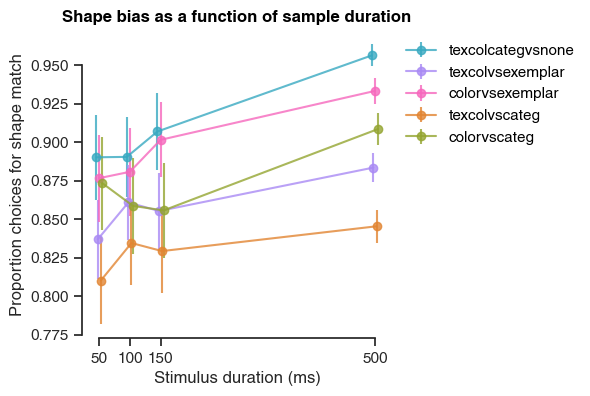

In [59]:
durations = [50, 100, 150, 500]
tasktypes = ['texcolcategvsnone', 'texcolvsexemplar','colorvsexemplar', 'texcolvscateg',  'colorvscateg',]
colors = sns.color_palette()
fig, ax = plt.subplots(figsize=(4,4))

xshifts = np.linspace(-5,5, len(tasktypes))

for ti, tasktype in enumerate(tasktypes):
    df = behav_df[behav_df.tasktype==tasktype]

    task_acc = df.groupby('sample_duration')['response'].mean().loc[durations]
    task_acc_sd = df.groupby('sample_duration')['response'].agg(SE).loc[durations]
    
    ax.errorbar(np.array(durations)+xshifts[ti], task_acc, yerr=task_acc_sd, color=colors[ti], ls='-', marker='o', label = tasktype, alpha=0.8)
# ax.plot([50, 500], [0.5, 0.5], ls='--', color=[.4, .4, .4])
ax.set_xticks(durations)
ax.set_title('Shape bias as a function of sample duration')
ax.set_xlabel('Stimulus duration (ms)')
ax.set_ylabel('Proportion choices for shape match')
ax.legend(frameon=False, bbox_to_anchor=[1.,1])
sns.despine(trim=True)
fig.savefig('figures/behavior_2025-01/human-behavior_shapebias-vs-duration.pdf',bbox_inches='tight', transparent=True)

In [124]:
df = behav_df[(behav_df.tasktype=='texcolvscateg')*(behav_df.sample_duration==500)].copy().reset_index(drop=True)
ucateg = df.sample_categ.unique()
uobject = df.sample_object.unique()

subj_corr = {'subject': [], 'corr': [], 'acc': []}
for si, subj in enumerate(df.subject_id.unique()):
    subj_df = df[df.subject_id==subj]
    subj_categ_acc = subj_df.groupby('sample_object')['response'].agg(np.nanmean).reindex(uobject)
    subj_acc = np.nanmean(subj_df.response)
    
    other_df = df[df.subject_id!=subj]
    other_categ_acc = other_df.groupby('sample_object')['response'].agg(np.nanmean).reindex(uobject)
    subj_corr['corr'].append( pd.DataFrame({'subj': subj_categ_acc, 'other': other_categ_acc}).corr().loc['subj', 'other'])
    subj_corr['subject'].append(subj)
    subj_corr['acc'].append(subj_acc)

In [1]:
sns.regplot(x=subj_corr['acc'], y=subj_corr['corr'],)

NameError: name 'sns' is not defined